In [26]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy.io import fits
import math as mth
import os
from scipy.optimize import curve_fit

plt.close('all')
plt.rcParams['figure.figsize'] = [8, 6]

In [82]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx
def ajuste_mas(fit):
    hdul = fits.open(fit)
    y = fits.getdata(fit)[0]
    head=hdul[0].header
    first = head['CRVAL1']
    step = head['CDELT1']
    vel = head['I-VBAR']
    beta = vel/c
    x2 = np.linspace(3763.75/(1+beta),(3763.75+len(y)*0.015625)/(1+beta),len(y))
    hdul.close()
    return x2, y
def ajuste_menos(fit):
    hdul = fits.open(fit)
    y = fits.getdata(fit)[0]
    head=hdul[0].header
    first = head['CRVAL1']
    step = head['CDELT1']
    vel = head['I-VBAR']
    beta = vel/c
    x2 = np.linspace(3763.75/(1-beta),(3763.75+len(y)*0.015625)/(1-beta),len(y))
    hdul.close()
    return x2, y
def gaussian_flux(x, a, sigma, mu):
    # Function to create a flux as a gaussian. It it normalized at 1. 
    r = 1+a/(sigma*np.sqrt(2*np.pi))*np.exp(-(x-mu)**2/(2*sigma**2))
    return(r)  
def adjust(function, data, pars0):
    # Function to adjust 3 values (a, sigma, mu). To do a more clear code. 
    pars, cov = curve_fit(f=function, xdata=data[0], ydata=data[1], p0=pars0, bounds=(-np.inf, np.inf))
    return(pars, cov) 
def Pars0(dat):   
    # Let's calculate here a first approximation for the initial values to iniciate 
    # the fit. It could improve the computing time.
    Mu = sum(dat[0])/len(dat[0])
    sigma2 = sum(dat[0]**2) /len(dat[0]) - Mu**2
    Sig = sigma2**0.5   
    Max = max(dat[1]-1)*Sig*np.sqrt(2*np.pi)    
    pars0 = [Max, Sig, Mu]
    return(pars0)
def fit_gaussian(central_ojo,ristra):
    x,y=ristra[0],ristra[1]
    E=find_nearest(x,central_ojo)
    A = max(abs(1-y[E[1]-100:E[1]+100]))
    E_min=find_nearest(y,min((y[E[1]-100:E[1]+100])))
    E_max=find_nearest(y,max((y[E[1]-100:E[1]+100])))
    if (E_max[0]-1)>(1-E_min[0]):
        E_min=E_max
    mask=abs(y[E_min[1]-400:E_min[1]+400]-1)>=0.15*(abs(1-E_min[0]))#y[E_min[1]-400:E_min[1]+400]<=0.93
    y_E=y[E_min[1]-400:E_min[1]+400]*mask
    x_E=x[E_min[1]-400:E_min[1]+400]*mask
    
    # Ajuste de gaussiana al perfil 
    X_E=[x_E[x_E !=0],y_E[y_E !=0]]
    pairs, covar=adjust(gaussian_flux,X_E,Pars0(X_E))
    x_lin=np.linspace(x_E[x_E !=0][0],x_E[x_E !=0][-1],100)
    return [x_lin,gaussian_flux(x_lin,*pairs),pairs]
def elem(fich,table):
    fichero= open(fich,'r')
    for lin in fichero:
        l = lin.split()
        try:
            table.append(float(l[0]))
        except:
            np.nan
    return table

In [28]:
data=fits.getdata('./HD2905_FH/HD2905_20160926_212934_M_V85000.fits')

In [29]:
# Creamos un ejemplo de un solo espectro para ver cómo queda y calibrar
plt.rcParams['figure.figsize'] = [8,6]
c = 299792.458
y = data[0]

In [30]:
# Listamos el contenido de los dos telescopios por separado. 
contenido = os.listdir('./HD2905_FH')
M_2905 = []
for file in contenido:
    if file.endswith('M_V85000.fits'):
        M_2905.append(file)
N_2905 = []
for file in contenido:
    if file.endswith('N_V46000.fits'):
        N_2905.append(file)        
print(len(contenido),len(M_2905),len(N_2905))

300 218 77


In [31]:
# Nos quedamos con la sección de línas de ISM con la corrección sumada o restada. 
f_mas=[]
f_menos=[]
for i in M_2905:
     res1,res2 = ajuste_mas('./HD2905_FH/'+i),ajuste_menos('./HD2905_FH/'+i)
     x1,x2=find_nearest(res1[0],5885),find_nearest(res1[0],5900)
     f_mas.append(res1[1][x1[1]:x2[1]])
     x1,x2=find_nearest(res2[0],5885),find_nearest(res2[0],5900)
     f_menos.append(res2[1][x1[1]:x2[1]]) 

0.1022069784325612
0.023952392680905845


(None, None)

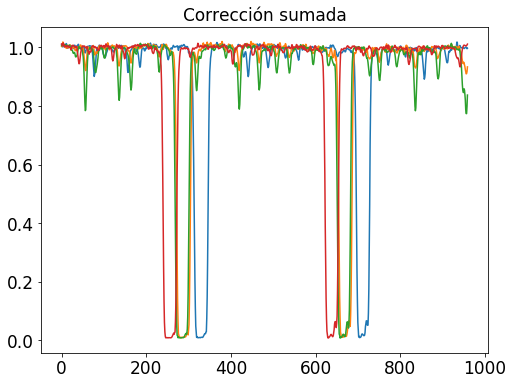

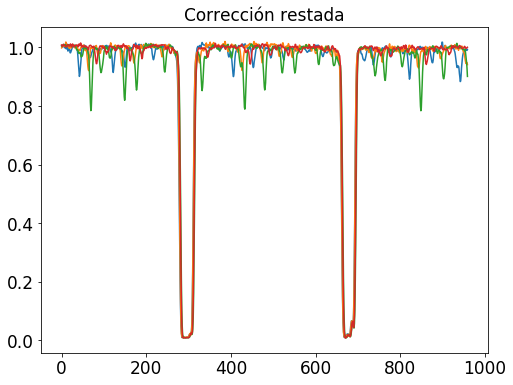

In [32]:
# Pintamos espectros distintos con ambas correcciones para comprobación rápida. 
plt.title('Corrección sumada',fontsize=17)
plt.plot(f_mas[0]),plt.plot(f_mas[50]),plt.plot(f_mas[100]),plt.plot(f_mas[200])
plt.tick_params(axis='y', labelsize=17),plt.tick_params(axis='x', labelsize=17)
plt.figure()
plt.title('Corrección restada',fontsize=17)
plt.plot(f_menos[0]),plt.plot(f_menos[50]),plt.plot(f_menos[100]),plt.plot(f_menos[200])
# Parece que la corrección "buena" es restar. Comprobamos buscando el menor residuo con TODOS los espectros. 
len(f_mas)
r_M,r_m=[],[]
for i in range(0,len(f_mas)):
    r_M.append(abs(f_mas[i][0:959]-f_mas[0][0:959])),r_m.append(abs(f_menos[i][0:959]-f_menos[0][0:959]))
print(np.mean((r_M))),print(np.mean((r_m)))
# Efectivamente, el residuo es menor restando. Esa es la corrección correcta. 
plt.tick_params(axis='y', labelsize=17),plt.tick_params(axis='x', labelsize=17)

In [33]:
# Sacamos la información de la cabecera 
hdul = fits.open('./HD2905_FH/HD2905_20160926_212934_M_V85000.fits')
head=hdul.info
hdul.close()

<Figure size 720x576 with 0 Axes>

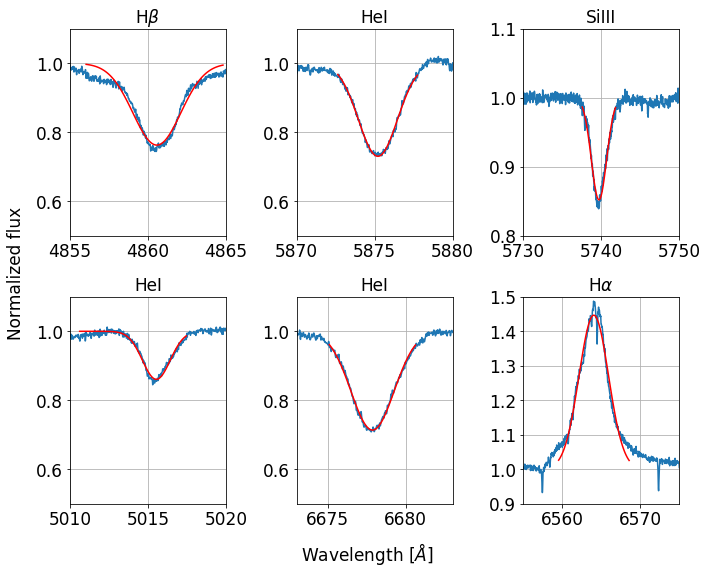

In [84]:
# Definimos una función que ajuste gaussianas a una línea dada, y vemos qué tal ajustan
X = ajuste_menos('./HD2905_FH/HD2905_20160926_212934_M_V85000.fits')





plt.rcParams['figure.figsize'] = [10,8]
plt.figure()
fig, ax = plt.subplots(2, 3)
fig.tight_layout(pad=4.0)
x = ajuste_menos('./HD2905_FH/HD2905_20160926_212934_M_V85000.fits')
ax[0, 0].grid(),ax[1, 0].grid(),ax[0, 1].grid(),ax[1, 1].grid(),ax[1, 2].grid(),ax[0, 2].grid()
ax[0, 0].plot(x[0],x[1]),ax[1, 0].plot(x[0],x[1]),ax[0, 1].plot(x[0],x[1]),ax[1, 1].plot(x[0],x[1])
ax[1, 2].plot(x[0],x[1]),ax[0,2].plot(x[0],x[1])
#plt.grid(),plt.tick_params(axis='x', labelsize=20),plt.tick_params(axis='y', labelsize=20)
#plt.xlabel(r'Wavelength ($\AA$)',fontsize=20),plt.ylabel(r'Normalized flux',fontsize=20),
ax[0, 0].set_ylim(0.5,1.1),ax[0, 0].set_xlim(4855,4865),ax[0,0].set_title(r'H$\beta$',fontsize=17)
ax[1, 0].set_ylim(0.5,1.1),ax[1, 0].set_xlim(5010,5020),ax[1,0].set_title(r'HeI',fontsize=17)
ax[0, 1].set_ylim(0.5,1.1),ax[0, 1].set_xlim(5870,5880),ax[0,1].set_title(r'HeI',fontsize=17)
ax[1, 1].set_ylim(0.5,1.1),ax[1,1].set_xlim(6673,6683),ax[1,1].set_title(r'HeI',fontsize=17)
ax[1, 2].set_ylim(0.9,1.5),ax[1,2].set_xlim(6555,6575),ax[1,2].set_title(r'H$\alpha$',fontsize=17)
ax[0, 2].set_ylim(0.8,1.1),ax[0,2].set_xlim(5730,5750),ax[0,2].set_title(r'SiIII',fontsize=17)
ax[0,0].tick_params(axis='y', labelsize=17),ax[0,0].tick_params(axis='x', labelsize=17)
ax[1,0].tick_params(axis='y', labelsize=17),ax[1,0].tick_params(axis='x', labelsize=17)
ax[0,1].tick_params(axis='y', labelsize=17),ax[0,1].tick_params(axis='x', labelsize=17)
ax[1,1].tick_params(axis='y', labelsize=17),ax[1,1].tick_params(axis='x', labelsize=17)
ax[1,2].tick_params(axis='y', labelsize=17),ax[1,2].tick_params(axis='x', labelsize=17)
ax[0,2].tick_params(axis='y', labelsize=17),ax[0,2].tick_params(axis='x', labelsize=17)
fig.text(0.5, 0.0, r'Wavelength [$\AA$]', ha='center',fontsize=17)
fig.text(0.0, 0.5, 'Normalized flux', va='center', rotation='vertical',fontsize=17)

# Vamos a ajustar gaussianas a todas estas líneas. 
Hbeta,HeI1=fit_gaussian(4860,X),fit_gaussian(5875,X)
HeI2,HeI3=fit_gaussian(5015,X),fit_gaussian(6678,X)
Halpha,SiIII=fit_gaussian(6564,X),fit_gaussian(5740,X)
ax[0,0].plot(Hbeta[0],Hbeta[1],color='r'),ax[0,1].plot(HeI1[0],HeI1[1],color='r')
ax[1,0].plot(HeI2[0],HeI2[1],color='r'),ax[1,1].plot(HeI3[0],HeI3[1],color='r')
ax[1,2].plot(Halpha[0],Halpha[1],color='r')
ax[0,2].plot(SiIII[0],SiIII[1],color='r')

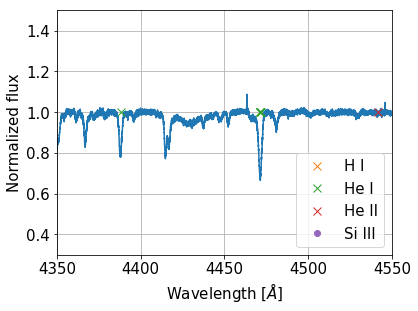

In [35]:
# Miramos distintos rangos para identificar líneas
HI,HeI,HeII=[],[],[]
elem('./lines/HI_air.txt',HI),elem('./lines/HeI_air.txt',HeI),elem('./lines/HeII_air.txt',HeII)
plt.rcParams['figure.figsize'] = [6,4.5]
plt.plot(X[0],X[1])
plt.plot(HI,np.ones((len(HI),1)),'x',markersize=8,label='H I')
plt.plot(HeI,np.ones((len(HeI),1)),'x',markersize=8,label='He I')
plt.plot(HeII,np.ones((len(HeII),1)),'x',markersize=8,label='He II')

plt.xlabel(r'Wavelength [$\AA$]',fontsize=15),plt.ylabel(r'Normalized flux',fontsize=15)
plt.tick_params(axis='y', labelsize=15),plt.tick_params(axis='x', labelsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.ylim(0.3,1.5),plt.xlim(4350,4550)

plt.plot(4553.8,1,'o',label='Si III')
plt.legend(fontsize=15)

0.08349667039419728 Velocity (km/s)= 5.498300330862719
0.3971743129668539 Velocity (km/s)= 20.26510669339769
0.2901541578821707 Velocity (km/s)= 13.025467860173256
Mean velocity (km/s)= 12.92962496147789


((0.3, 1.5), (4540, 4560))

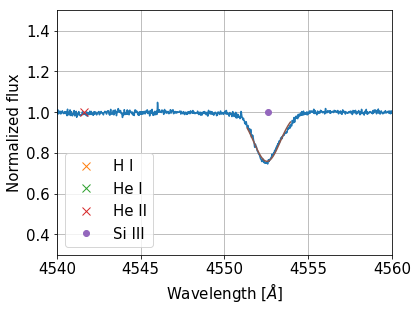

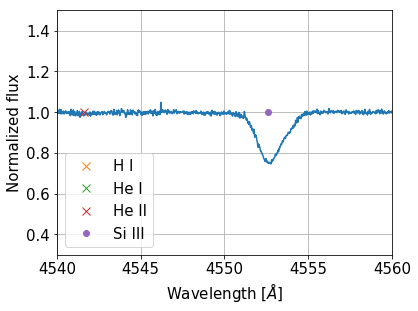

In [36]:
# Sacamos la velocidad intrínseca que pueda tener la estrella para corregir. 
# Si fuese necesario, esto se podría llegar a automatizar en una función. 
plt.plot(X[0],X[1])
plt.plot(HI,np.ones((len(HI),1)),'x',markersize=8,label='H I')
plt.plot(HeI,np.ones((len(HeI),1)),'x',markersize=8,label='He I')
plt.plot(HeII,np.ones((len(HeII),1)),'x',markersize=8,label='He II')

plt.xlabel(r'Wavelength [$\AA$]',fontsize=15),plt.ylabel(r'Normalized flux',fontsize=15)
plt.tick_params(axis='y', labelsize=15),plt.tick_params(axis='x', labelsize=15)
plt.plot(4552.62,1,'o',label='Si III')
plt.legend(fontsize=15)
plt.grid()
plt.ylim(0.3,1.5),plt.xlim(4540,4560)

gauss_Si=fit_gaussian(4552.5,X)
plt.plot(gauss_Si[0],gauss_Si[1])
Dl_Si= 4552.62-gauss_Si[2][2]
v_Si=c*Dl_Si/4552.62
print(Dl_Si,'Velocity (km/s)=',v_Si)


gauss_HeI1=fit_gaussian(5875,X)
plt.plot(gauss_HeI1[0],gauss_HeI1[1])
Dl_HeI1= 5875.61-gauss_HeI1[2][2]
v_He1=c*Dl_HeI1/5875.61
print(Dl_HeI1,'Velocity (km/s)=',v_He1)

gauss_HeI2=fit_gaussian(6678,X)
plt.plot(gauss_HeI2[0],gauss_HeI2[1])
Dl_HeI2= 6678.15-gauss_HeI2[2][2]
v_He2=c*Dl_HeI2/6678.15
print(Dl_HeI2,'Velocity (km/s)=',v_He2)



v_int=(v_Si+v_He1+v_He2)/3
print('Mean velocity (km/s)=',v_int)
# Aplicamos la corrección
beta=v_int/c
x3 = X[0]/(1-beta)
# Comprobamos que es correcata
plt.figure()
plt.plot(x3,X[1])
plt.plot(HI,np.ones((len(HI),1)),'x',markersize=8,label='H I')
plt.plot(HeI,np.ones((len(HeI),1)),'x',markersize=8,label='He I')
plt.plot(HeII,np.ones((len(HeII),1)),'x',markersize=8,label='He II')

plt.xlabel(r'Wavelength [$\AA$]',fontsize=15),plt.ylabel(r'Normalized flux',fontsize=15)
plt.tick_params(axis='y', labelsize=15),plt.tick_params(axis='x', labelsize=15)
plt.plot(4552.62,1,'o',label='Si III')
plt.legend(fontsize=15)
plt.grid()
plt.ylim(0.3,1.5),plt.xlim(4540,4560)

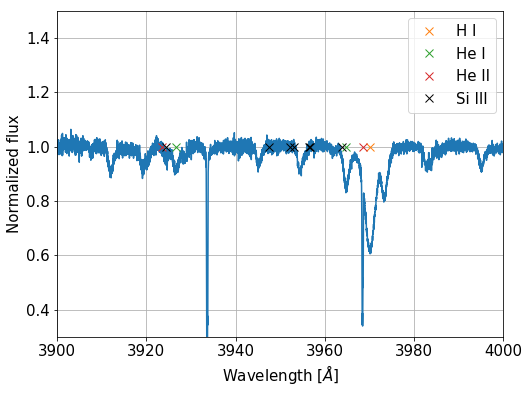

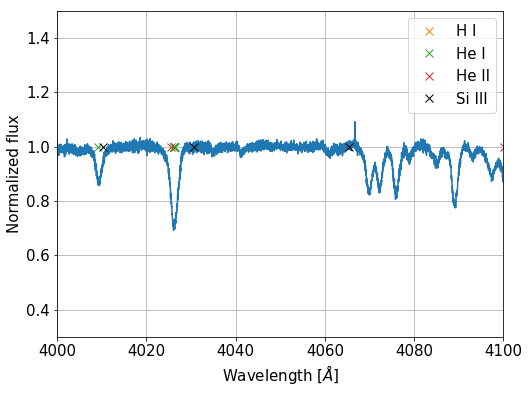

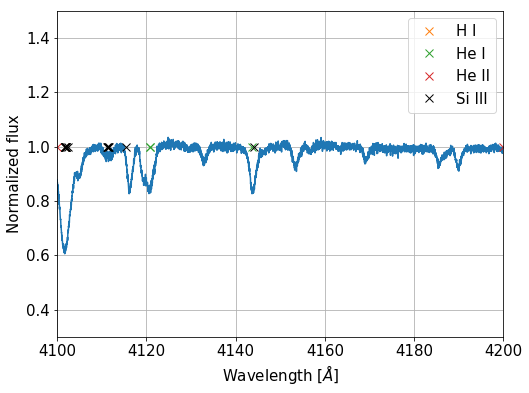

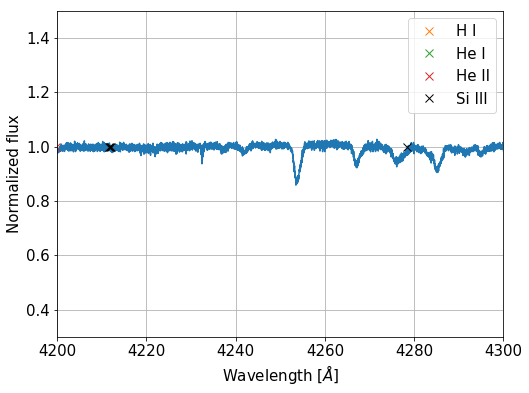

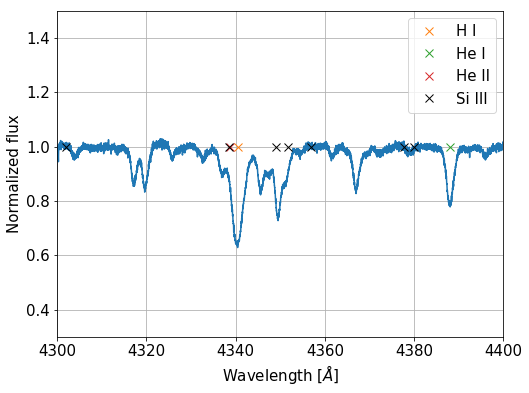

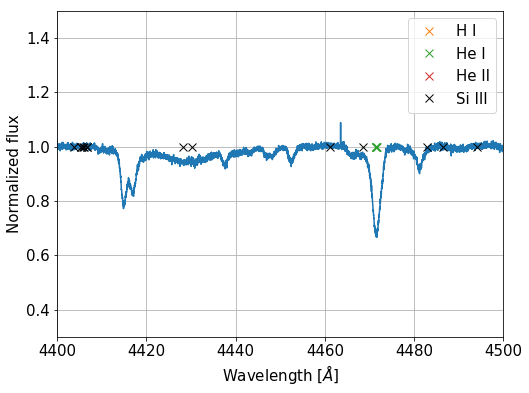

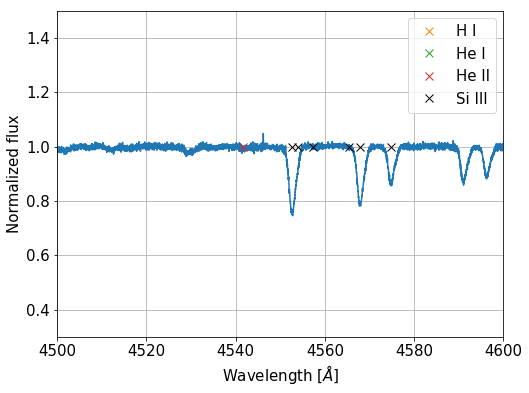

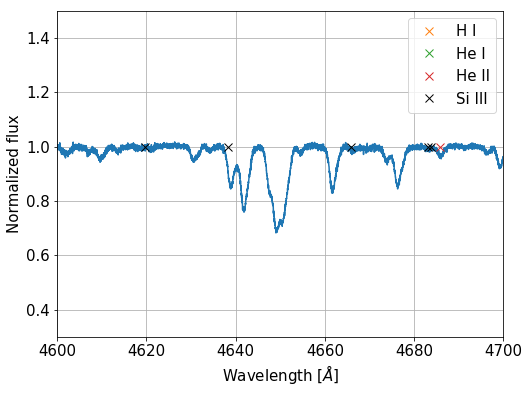

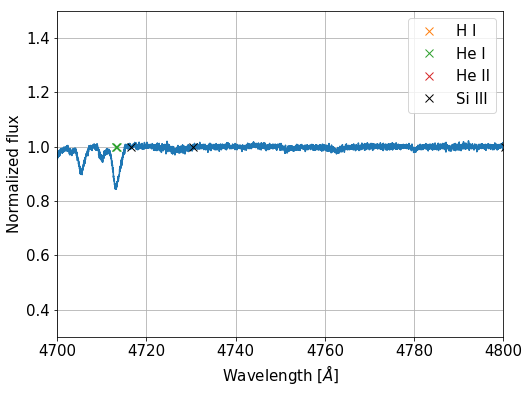

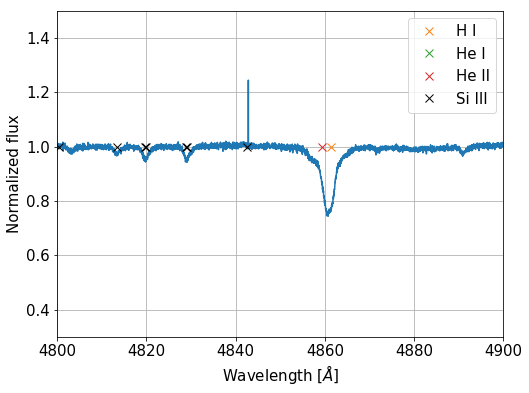

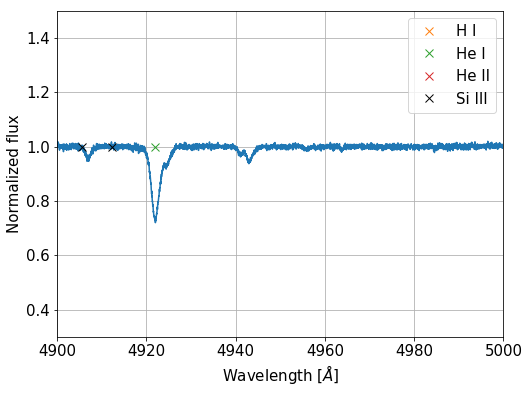

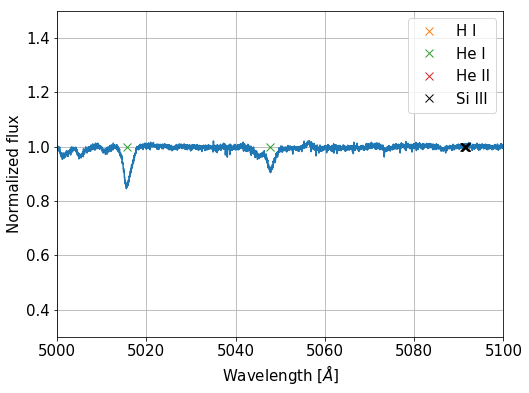

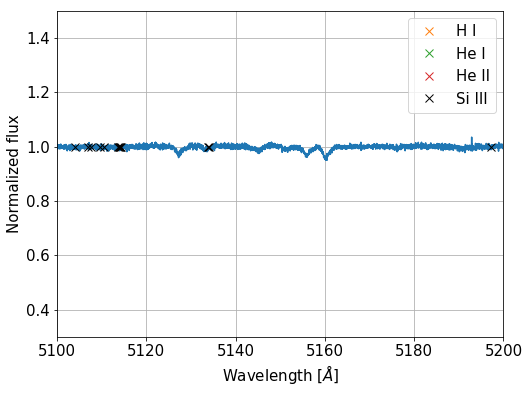

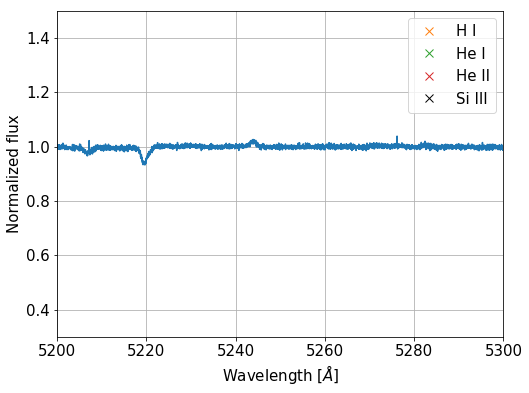

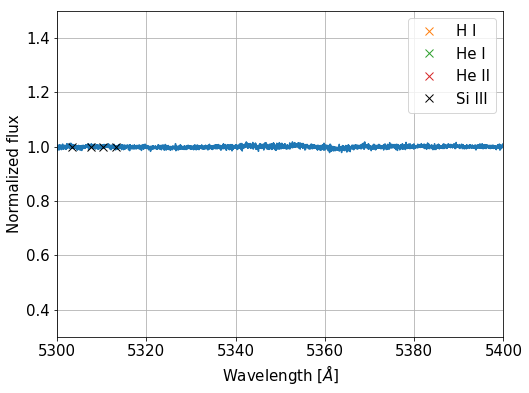

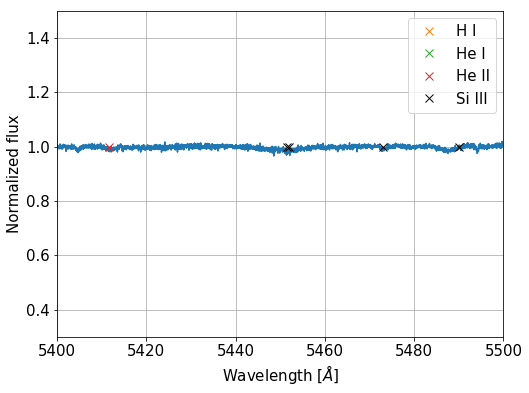

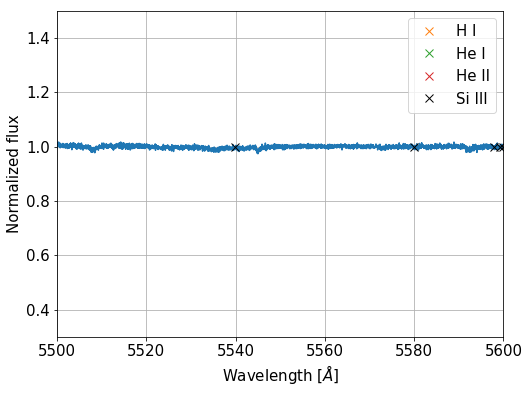

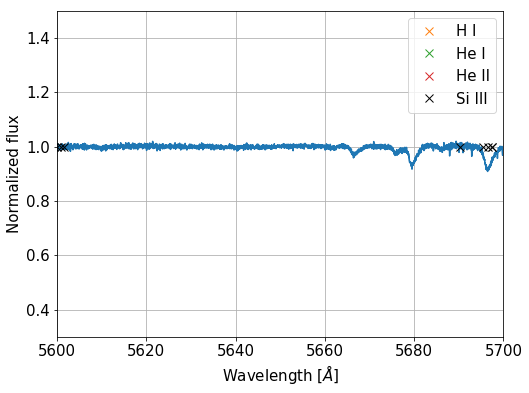

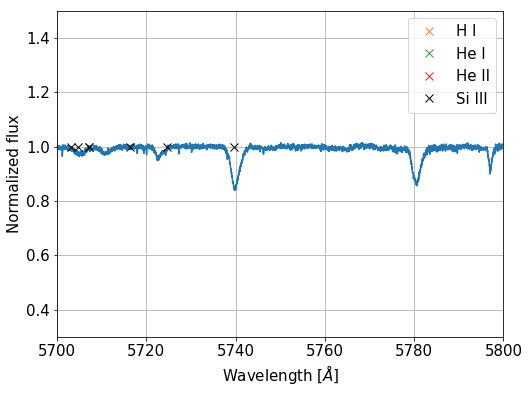

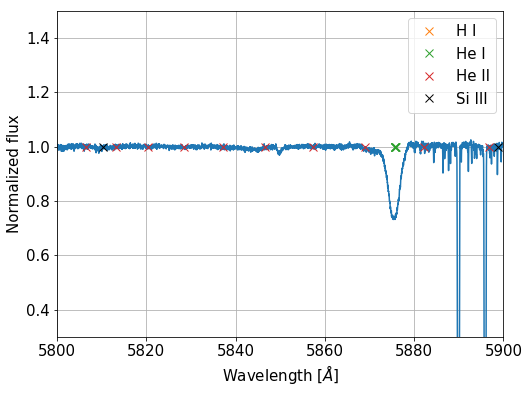

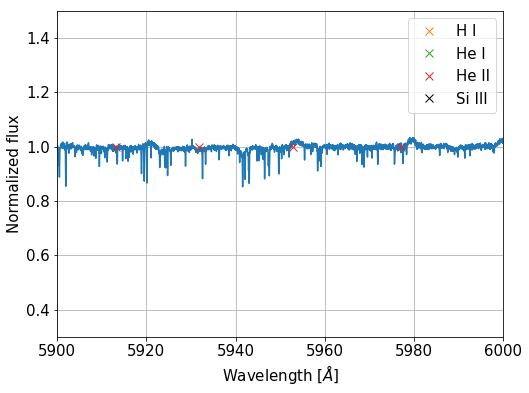

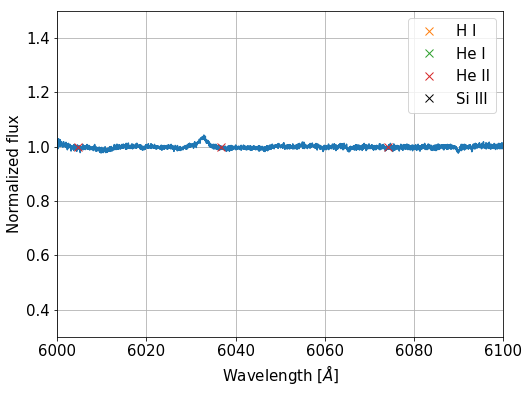

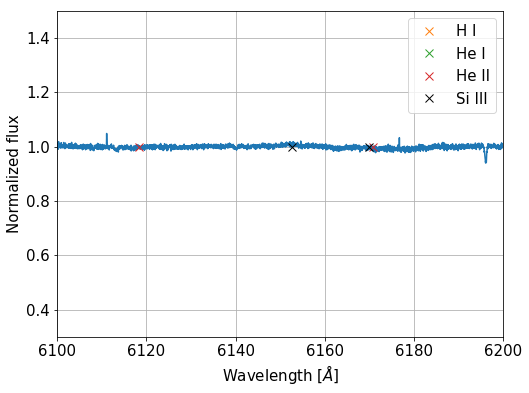

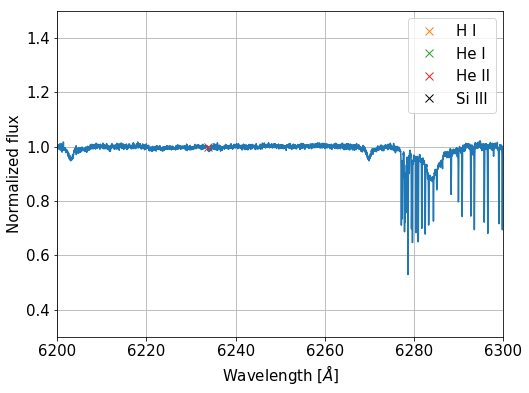

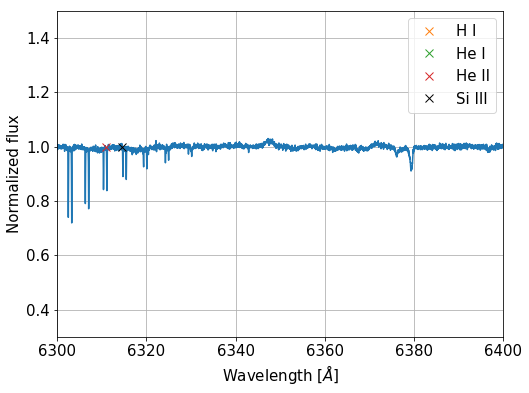

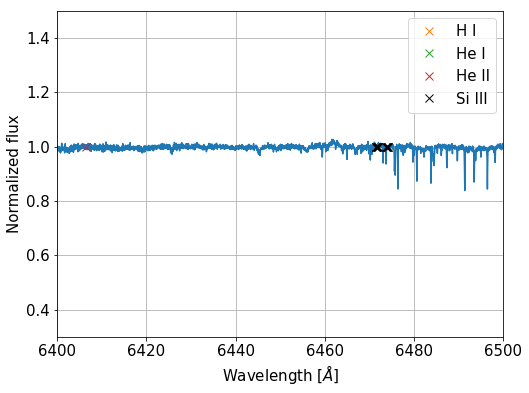

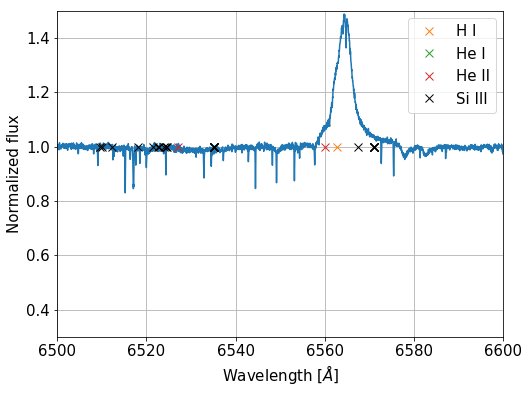

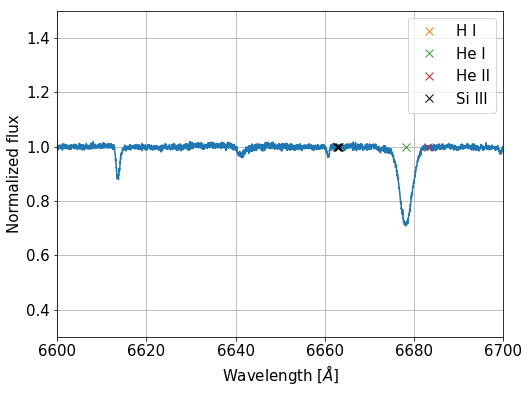

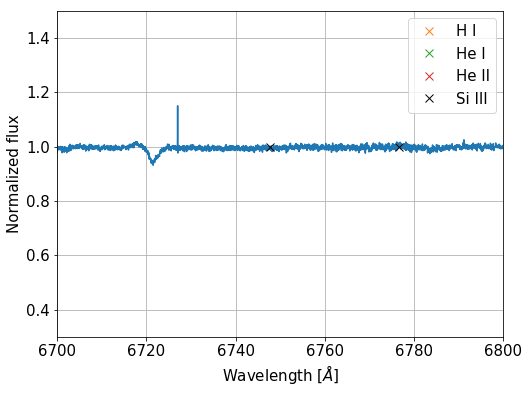

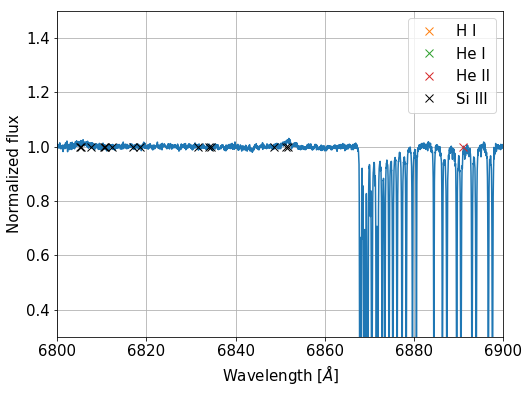

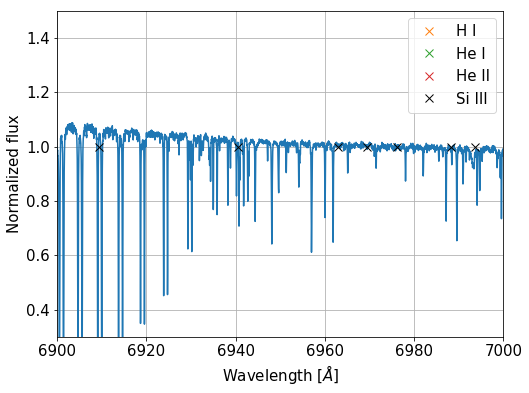

In [37]:
# Una vez hechas estas correcciones, podemos pasar ya a identificar las líneas. 
plt.rcParams['figure.figsize'] = [8,6]
i=0
SiIII=[]
elem('./lines/SiIII_air.txt',SiIII)
for i in range(0,31):
    plt.figure()
    plt.plot(x3,X[1])
    plt.plot(HI,np.ones((len(HI),1)),'x',markersize=8,label='H I')
    plt.plot(HeI,np.ones((len(HeI),1)),'x',markersize=8,label='He I')
    plt.plot(HeII,np.ones((len(HeII),1)),'x',markersize=8,label='He II')

    plt.xlabel(r'Wavelength [$\AA$]',fontsize=15),plt.ylabel(r'Normalized flux',fontsize=15)
    plt.tick_params(axis='y', labelsize=15),plt.tick_params(axis='x', labelsize=15)
    plt.legend(fontsize=15)
    plt.plot(SiIII,np.ones((len(SiIII),1)),'kx',markersize=8,label='Si III')
    plt.ylim(0.3,1.5),plt.xlim(3900+i*100,3900+(i+1)*100)
    plt.grid()
    plt.legend(fontsize=15)




- Sacar líneas metálicas.
- Elegir buenas líneas--> Buenas, reserva, descartes.  
- Traducir el programa. 
